# Module 6: Similarity and Distance Measures

# Set Up

## Config

We define two OHCO lists, one to match the reduced TFIDF table we are importing, and the other to define the table after we compress this table to make clustering easier.

In [ ]:
OHCO_src = ['book_id', 'chap_num']
OHCO = ['book_id']

## Import

In [ ]:
import pandas as pd
import numpy as np
import re 
from numpy.linalg import norm
from scipy.spatial.distance import pdist

In [ ]:
import seaborn as sns
sns.set(style="ticks")

%matplotlib inline

# Prepare the Data

## Import tables

In [ ]:
TFIDF = pd.read_csv('../MOD05--VSM/TFIDF_REDUCED.csv').set_index(OHCO_src)
VOCAB = pd.read_csv('../MOD05--VSM/VOCAB2.csv').set_index('term_id')
LIB = pd.read_csv('../MOD04--DataModel/LIB.csv').set_index('book_id')

In [ ]:
# TFIDF.head()

## Add Some Labels to the Library

In [ ]:
LIB.loc[LIB.book_title.str.contains('Austen'), 'author'] = 'austen'
LIB.loc[LIB.book_title.str.contains('Melville'), 'author'] = 'melville'
LIB['author'] = LIB['author'].fillna('melville')
LIB['title'] = LIB.book_title.str.split(', by').apply(lambda x: x[0])

In [ ]:
LIB

,book_title,book_file,author,title
book_id,,,,
158,"Emma, by Jane Austen",epubs/AUSTEN_JANE_EMMA-pg158.txt,austen,Emma
946,"Lady Susan, by Jane Austen",epubs/AUSTEN_JANE_LADY_SUSAN-pg946.txt,austen,Lady Susan
1212,"Love And Freindship And Other Early Works, by ...",epubs/AUSTEN_JANE_LOVE_AND_FREINDSHIP_SIC_-pg1...,austen,Love And Freindship And Other Early Works
141,"Mansfield Park, by Jane Austen",epubs/AUSTEN_JANE_MANSFIELD_PARK-pg141.txt,austen,Mansfield Park
121,"Northanger Abbey, by Jane Austen",epubs/AUSTEN_JANE_NORTHANGER_ABBEY-pg121.txt,austen,Northanger Abbey
105,"Persuasion, by Jane Austen",epubs/AUSTEN_JANE_PERSUASION-pg105.txt,austen,Persuasion
1342,"Pride and Prejudice, by Jane Austen",epubs/AUSTEN_JANE_PRIDE_AND_PREJUDICE-pg1342.txt,austen,Pride and Prejudice
161,"Sense and Sensibility, by Jane Austen",epubs/AUSTEN_JANE_SENSE_AND_SENSIBILITY-pg161.txt,austen,Sense and Sensibility
15422,"Israel Potter, by Herman Melville",epubs/MELVILLE_HERMAN_ISRAEL_POTTER_HIS_FIFTY_...,melville,Israel Potter


## Collapse TFIDF

We want to work with larger bags in this notebook, in order to better visualize our resulting clusters.

In [ ]:
TFIDF = TFIDF.groupby(OHCO).mean()

In [ ]:
TFIDF.head()

,20533,3532,21581,34916,22134,24746,30789,12385,24524,3323,...,25958,32591,20661,5344,34924,36782,24303,10403,34840,5488
book_id,,,,,,,,,,,,,,,,,,,,,
105,0.001887,0.002399,0.003255,0.004287,0.003074,0.001730,0.003642,0.002494,0.002569,0.002258,...,0.000570,0.000000,0.001238,0.000570,0.000000,0.000000,0.002218,0.000000,0.000000,0.000000
121,0.001599,0.001851,0.002074,0.003126,0.005288,0.002194,0.003204,0.001572,0.003853,0.003174,...,0.000387,0.000000,0.000577,0.000721,0.001015,0.000000,0.000386,0.000802,0.000000,0.004574
141,0.003472,0.001552,0.003258,0.004266,0.004211,0.001829,0.003158,0.002020,0.002004,0.001397,...,0.000000,0.000193,0.001989,0.001273,0.002375,0.000278,0.001114,0.000249,0.000892,0.000000
158,0.001002,0.001770,0.004479,0.004982,0.004397,0.002342,0.004243,0.002580,0.003258,0.001863,...,0.000698,0.000000,0.001220,0.000272,0.002610,0.000249,0.000987,0.000000,0.001422,0.000000
161,0.002941,0.001975,0.002101,0.002949,0.004071,0.003410,0.004451,0.002232,0.003471,0.002185,...,0.000000,0.000000,0.001848,0.000324,0.000443,0.000576,0.000372,0.000702,0.000000,0.000000


## Create a DOC table

We want to create a new table that maps the OHCO levels to a single doc_id. We do this so that when we create a table to store pairs of docs and their distances, we can use a single-valued ID for each docs. 

This table will also be used to store cluster assignments.

All of this will become clearer below!

In [ ]:
DOC = TFIDF.reset_index()[OHCO] # We create a table from the OHCO in our TFIDF table

In [ ]:
DOC.head()

,book_id
0,105
1,121
2,141
3,158
4,161


In [ ]:
DOC.index.name = 'doc_id' # We give the new index a name

In [ ]:
DOC.head()

,book_id
doc_id,
0,105
1,121
2,141
3,158
4,161


## Add a meaningful Title to DOC index

In [ ]:
DOC['title'] = DOC.book_id.map(LIB.author) \
    + '-' + DOC[OHCO].apply(lambda x: x.astype('str').str.cat(sep='-'), 1) \
    + ': '+ DOC.book_id.map(LIB.title) 

In [ ]:
DOC.head()

,book_id,title
doc_id,,
0,105,austen-105: Persuasion
1,121,austen-121: Northanger Abbey
2,141,austen-141: Mansfield Park
3,158,austen-158: Emma
4,161,austen-161: Sense and Sensibility


## Create Normalized Tables

In [ ]:
L0 = TFIDF.astype('bool').astype('int')
L1 = TFIDF.apply(lambda x: x / x.sum(), 1)
L2 = TFIDF.apply(lambda x: x / norm(x), 1)

In [ ]:
# ((L2.T)**2).sum()

## Create Doc Pair Table

Create a table to store our results.

Note that `pist()` is a "distance matrix computation from a collection of raw observation vectors stored in a rectangular array".

In [ ]:
PAIRS = pd.DataFrame(index=pd.MultiIndex.from_product([DOC.index.tolist(), DOC.index.tolist()])).reset_index()
PAIRS = PAIRS[PAIRS.level_0 < PAIRS.level_1].set_index(['level_0','level_1'])
PAIRS.index.names = ['doc_a', 'doc_b']

In [ ]:
PAIRS.shape

(190, 0)

In [ ]:
PAIRS.head()

Empty DataFrame
Columns: []
Index: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]

# Compute Distances

In [ ]:
%time PAIRS['cityblock'] = pdist(TFIDF, 'cityblock')

CPU times: user 2.83 ms, sys: 1.46 ms, total: 4.29 ms
Wall time: 2.57 ms


In [ ]:
%time PAIRS['euclidean'] = pdist(TFIDF, 'euclidean')

CPU times: user 3.01 ms, sys: 1.33 ms, total: 4.33 ms
Wall time: 2.57 ms


In [ ]:
%time PAIRS['cosine'] = pdist(TFIDF, 'cosine')

CPU times: user 2.6 ms, sys: 1.18 ms, total: 3.78 ms
Wall time: 2.49 ms


In [ ]:
%time PAIRS['jaccard'] = pdist(L0, 'jaccard') # Fast, and similar to js

CPU times: user 2.88 ms, sys: 1.71 ms, total: 4.59 ms
Wall time: 3.11 ms


In [ ]:
%time PAIRS['dice'] = pdist(L0, 'dice')

CPU times: user 3.12 ms, sys: 1.26 ms, total: 4.38 ms
Wall time: 3.42 ms


In [ ]:
%time PAIRS['js'] = pdist(L1, 'jensenshannon') # Turns out to be really slow

CPU times: user 26.7 ms, sys: 1.79 ms, total: 28.5 ms
Wall time: 29.3 ms


In [ ]:
%time PAIRS['euclidean2'] = pdist(L2, 'euclidean') # Should be the same as cosine (colinear)

CPU times: user 3.34 ms, sys: 1.36 ms, total: 4.7 ms
Wall time: 3.18 ms


In [ ]:
# %time PAIRS['js2'] = pdist(TFIDF, 'jensenshannon')

In [ ]:
PAIRS.head()

cityblock  euclidean    cosine   jaccard      dice        js  \
doc_a doc_b                                                                 
0     1       3.758106   0.112777  0.279551  0.248631  0.141964  0.340929   
      2       3.231648   0.126583  0.322359  0.204600  0.113958  0.302108   
      3       3.344513   0.143222  0.356725  0.212112  0.118638  0.303812   
      4       3.805001   0.149670  0.382078  0.220552  0.123944  0.330658   
      5       5.055358   0.169157  0.500020  0.459033  0.297886  0.466605   

             euclidean2  
doc_a doc_b              
0     1        0.747731  
      2        0.802944  
      3        0.844660  
      4        0.874160  
      5        1.000020

## Compare Distributions

In [ ]:
if PAIRS.shape[0] > 1000:
    SAMPLE = PAIRS.sample(1000)
else:
    SAMPLE = PAIRS

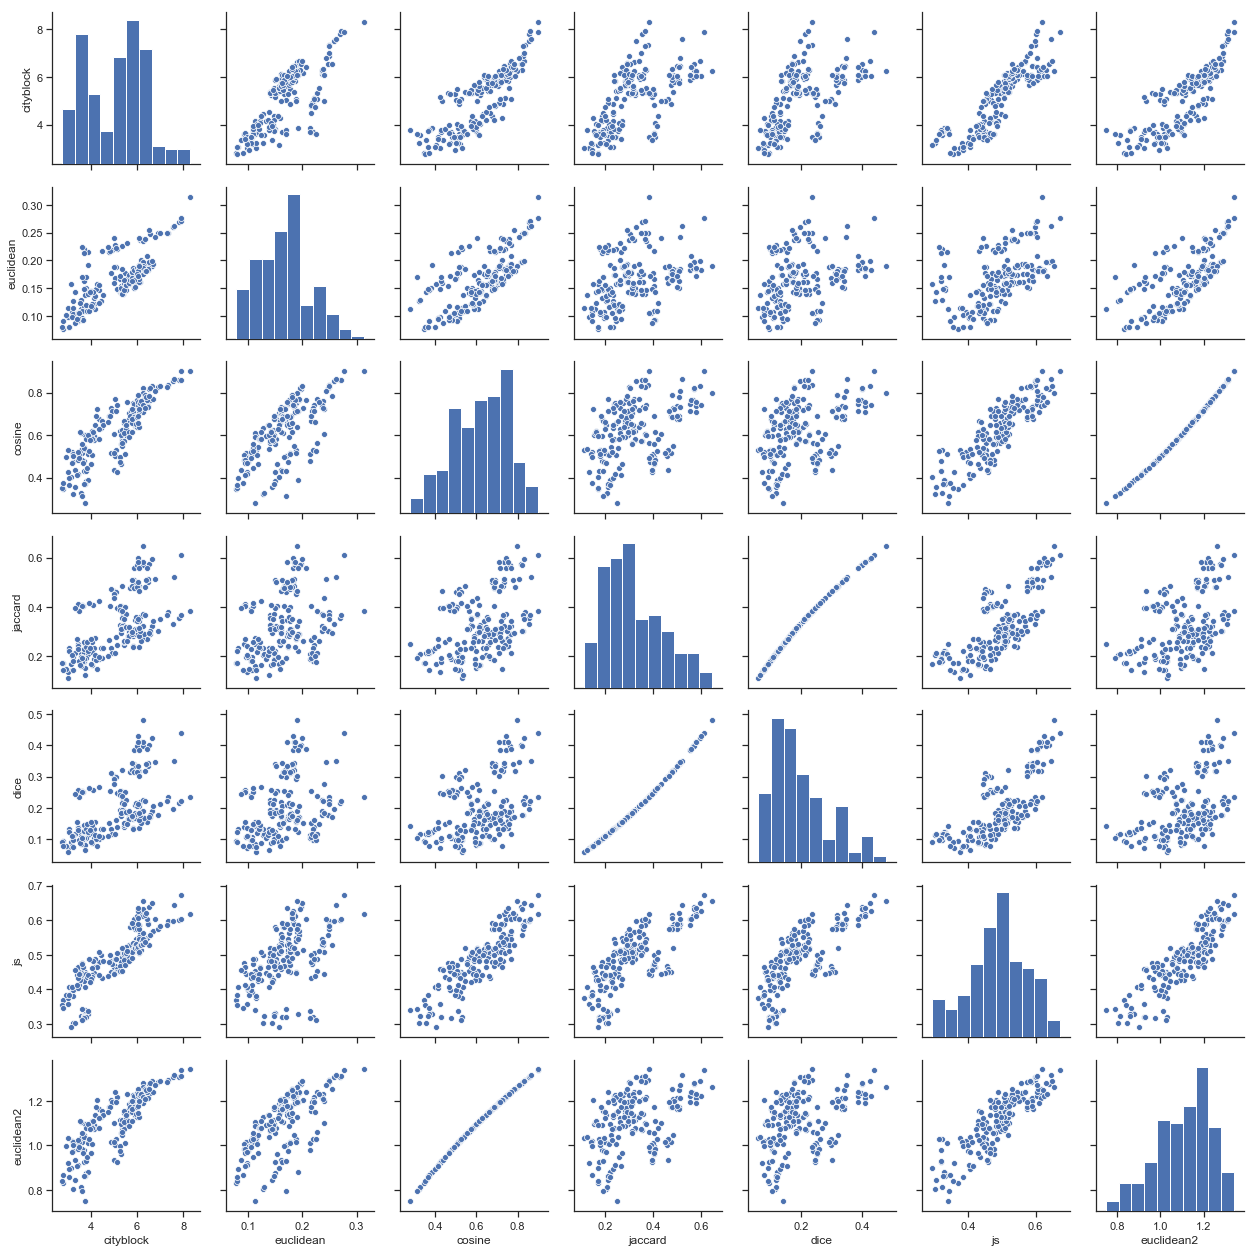

In [ ]:
sns.pairplot(SAMPLE)

In [ ]:
PAIRS.sort_values('cosine').head(20).style.background_gradient('YlGn')

,,cityblock,euclidean,cosine,jaccard,dice,js,euclidean2
doc_a,doc_b,,,,,,,
0,1,3.75811,0.112777,0.279551,0.248631,0.141964,0.340929,0.747731
13,14,3.62257,0.169675,0.313791,0.190689,0.105393,0.342567,0.792201
0,2,3.23165,0.126583,0.322359,0.2046,0.113958,0.302108,0.802944
1,2,3.58624,0.129093,0.329896,0.209625,0.117084,0.323488,0.812276
8,10,2.80137,0.0772126,0.345793,0.171875,0.0940171,0.370936,0.831616
10,11,2.76094,0.0799986,0.35196,0.169301,0.0924788,0.354745,0.839
0,3,3.34451,0.143222,0.356725,0.212112,0.118638,0.303812,0.84466
11,15,3.04864,0.0799782,0.366671,0.219346,0.123183,0.384286,0.856353
1,4,3.71811,0.148105,0.36951,0.211973,0.118551,0.324246,0.859663


In [ ]:
# def get_comps(doc_id):
#     idx = pd.IndexSlice
#     a = PAIRS.loc[idx[doc_id, :], :]
#     b = PAIRS.loc[idx[:, doc_id], :]
#     return pd.concat([a,b])

# Create Clusters

## Hiearchical

In [1]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

In [2]:
def hca(sims, linkage_method='ward', color_thresh=.3, figsize=(10, 10)):
    tree = sch.linkage(sims, method=linkage_method)
    labels = DOC.title.values
    plt.figure()
    fig, axes = plt.subplots(figsize=figsize)
    dendrogram = sch.dendrogram(tree, 
                                labels=labels, 
                                orientation="left", 
                                count_sort=True,
                                distance_sort=True,
                                above_threshold_color='.75',
                                color_threshold=color_thresh
                               )
    plt.tick_params(axis='both', which='major', labelsize=14)

In [3]:
hca(PAIRS.cosine, color_thresh=1)

NameError: ignored

In [ ]:
hca(PAIRS.jaccard, color_thresh=.6)

In [ ]:
hca(PAIRS.euclidean, color_thresh=.3)

In [ ]:
hca(PAIRS.cityblock, color_thresh=8)

In [ ]:
hca(PAIRS.js, color_thresh=.6)

## K-Means

K-Means *only* uses Euclidean distance. Why?

* The K-Means procedure does not explicitly use pairwise distances between data points. 
* Instead, it repeatedly assigns points to the closest centroid thereby using Euclidean distance from data points to a centroid. 
* However, K-Means is *implicitly* based on pairwise Euclidean distances between data points, because the sum of squared deviations from centroid is equal to the sum of pairwise squared Euclidean distances divided by the number of points. 
* The term "centroid" is itself from Euclidean geometry. It is multivariate mean in Euclidean space. Euclidean space is about euclidean distances. Non-Euclidean distances will generally not span Euclidean space. That's why K-Means is for Euclidean distances only.

See the [Cross Validated](https://stats.stackexchange.com/questions/81481/why-does-k-means-clustering-algorithm-use-only-euclidean-distance-metric) post on this.

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
n_clusters = 4

In [ ]:
DOC['y_raw'] = KMeans(n_clusters).fit_predict(TFIDF)
DOC['y_L0'] = KMeans(n_clusters).fit_predict(L0)
DOC['y_L1'] = KMeans(n_clusters).fit_predict(L1)
DOC['y_L2'] = KMeans(n_clusters).fit_predict(L2)

In [ ]:
DOC.sort_values('y_raw').style.background_gradient(cmap='viridis')

,book_id,title,y_raw,y_L0,y_L1,y_L2
doc_id,,,,,,
0,105,austen-105: Persuasion,0,2,3,1
1,121,austen-121: Northanger Abbey,0,2,3,1
2,141,austen-141: Mansfield Park,0,2,3,1
3,158,austen-158: Emma,0,2,3,1
4,161,austen-161: Sense and Sensibility,0,2,3,1
5,946,austen-946: Lady Susan,0,1,2,1
6,1212,austen-1212: Love And Freindship And Other Early Works,0,1,3,1
17,21816,melville-21816: The Confidence - Man,1,0,0,2
16,15859,melville-15859: The Piazza Tales,1,3,0,2
